<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab16_googlenet_cifar_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB16: GoogLenet for imagenet

Inception을 구현하여 GoogLenet을 구현해보자 
- ImageNet datatset을 위한 실험


In [1]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import cv2
import numpy as np

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

TensorFlow 2.x selected.


In [2]:
  # for Tensorboard use
  LOG_DIR = 'drive/data/tb_logs'
	
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
	
  import os
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
	  
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR))
	
  get_ipython().system_raw('./ngrok http 6006 &')
	
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-16 16:24:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.206.168.246, 52.204.223.154, 34.193.139.214, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.206.168.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  28.2MB/s    in 0.5s    

2020-01-16 16:24:39 (28.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://517ac59f.ngrok.io


In [3]:
# dataset loading part
# 데이터 파이프라인 부분 

cifar100 = tf.keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train.shape = %s" % str(x_train.shape))
print("y_train.shape = %s" % str(x_train.shape))

x_train = x_train.reshape([x_train.shape[0],
                           x_train.shape[1],
                           x_train.shape[2],3])

x_test = x_test.reshape([x_test.shape[0],
                           x_test.shape[1],
                           x_test.shape[2],3])


x_train = np.array(tf.keras.backend.resize_images(x_train, height_factor=2,width_factor=2, data_format='channels_last',interpolation='bilinear'))
x_test = np.array(tf.keras.backend.resize_images(x_test, height_factor=2,width_factor=2, data_format='channels_last',interpolation='bilinear'))

print("x_train.shape = %s" % str(x_train.shape))
print("x_test.shape = %s" % str(x_test.shape))

print("y_train.shape = %s" % str(y_train.shape))
print("y_test.shape = %s" % str(y_test.shape))

input_shape = x_train.shape[1]

169009152/169001437 [==============================] - 2s 0us/step
x_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 32, 32, 3)
x_train.shape = (50000, 64, 64, 3)
x_test.shape = (10000, 64, 64, 3)
y_train.shape = (50000, 1)
y_test.shape = (10000, 1)


In [0]:
# Network modules
def conv_batchnorm_relu(net_in,filters,kernel_size,strides):
  net = tf.keras.layers.Conv2D(filters,kernel_size=(kernel_size,kernel_size),
                               strides=(strides,strides),
                               padding='same',
                               kernel_initializer='he_normal',
                               activation=None)(net_in)
  net = tf.keras.layers.BatchNormalization()(net)
  net = tf.keras.layers.Activation(activation='relu')(net)
  return net


def reduced_conv(net_in,reduced_chdim,filters,kernel_size,strides):
  net = conv_batchnorm_relu(net_in,reduced_chdim,1,1)
  net = conv_batchnorm_relu(net,filters,kernel_size,strides)
  return net


def inception(net_in,chdim1x1,chdim3x3reduce,chdim3x3,chdim5x5reduce,chdim5x5,maxproj,name):
  with tf.keras.backend.name_scope(name):
    net1  = conv_batchnorm_relu(net_in,filters=chdim1x1,
                                kernel_size=1,
                                strides=1)
    net2 = reduced_conv(net_in,chdim3x3reduce,chdim3x3,kernel_size=3,strides=1)
    net3 = reduced_conv(net_in,chdim5x5reduce,chdim5x5,kernel_size=5,strides=1)
    net4 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(net_in)
    net4 = conv_batchnorm_relu(net4,maxproj,1,1)
    net = tf.keras.layers.concatenate([net1,net2,net3,net4],axis=3)
  return net

# googlenet model
net_in = tf.keras.layers.Input(shape=(input_shape,input_shape,3))
net = tf.keras.layers.Conv2D(64,kernel_size=(9,9),strides=1,padding='valid', kernel_initializer='he_normal',activation='relu')(net_in)
net = conv_batchnorm_relu(net,filters=192,kernel_size=3,strides=1)
net = inception(net,64,96,128,16,32,32,name='inception3a')  
net = inception(net,128,128,192,32,96,64,name='inception4b')
net = tf.keras.layers.MaxPool2D(pool_size=[3,3],strides=2)(net)
net = inception(net,192,96,208,16,48,64,name='inception4a')
net = inception(net,160,112,224,24,64,64,name='inception4b')
net = inception(net,128,128,256,24,64,64,name='inception4c')  
net = inception(net,112,144,288,32,64,64,name='inception4d')
net = inception(net,256,160,320,32,128,128,name='inceptioin4e')
net = tf.keras.layers.MaxPool2D(pool_size=[3,3],strides=2)(net)
net = inception(net,256,160,320,32,128,128,name='inception5a')
net = inception(net,384,192,384,48,128,128,name='inception5b')
net = tf.keras.layers.GlobalAvgPool2D(data_format='channels_last')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(units=1000,activation='softmax')(net)

model = tf.keras.models.Model(inputs=net_in,outputs=net)


opt_fn = tf.keras.optimizers.Adam(learning_rate=1e-3,
                                beta_1=0.9,
                                beta_2=0.999)

# 'sparse_categorical_crossentropy' is for integer labels
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_images=True)

In [0]:
# model training and evaluation part
training_epochs = 20
batch_size = 128
model.summary()
model.fit(x_train, y_train, 
          epochs=training_epochs,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          callbacks=[tensorboard_callback])
model.evaluate(x_test,  y_test, verbose=2)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_490 (Conv2D)             (None, 56, 56, 64)   15616       input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_491 (Conv2D)             (None, 56, 56, 192)  110784      conv2d_490[0][0]                 
__________________________________________________________________________________________________
batch_normalization_476 (BatchN (None, 56, 56, 192)  768         conv2d_491[0][0]                 
____________________________________________________________________________________________

model prediction = 33


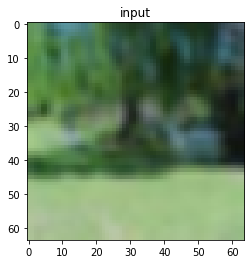

In [0]:
# prediction 

test_input = x_test[300,:,:,:]
pred_y = model.predict(test_input.reshape([1,64,64,3]))

plt.figure(1)
plt.imshow(test_input.reshape([64,64,3]))
plt.title("input")
print("model prediction = %s"% pred_y.argmax())
